In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pystan
import arviz as az
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Some Elementary statistics

In [2]:
model_path = '../stan_models'
data_file = '../data/data.txt'
accident_data = np.loadtxt(data_file)
print(accident_data.shape)
mean_value = np.mean(accident_data) # mean value approximately 25 cases per 10,000 people
# it's very un likely to change 50% of the mean, so 2.57*sigma = mean_value/2
sigma = mean_value / (2*2.57) 
sigma

(6, 15)


4.854734111543451

In [3]:
### UK population by year from 2005 to 2019
population_by_year = np.array([60413300,60827100,61319100,61823800,
                               62260500,62759500,63285100,63705000,
                               64105700,64596800,65110000,65648100,
                               66040200,66435600,66796800])

In [4]:
area_names = ["Metropolitan Police", 'Cumbria','Lancashire',
               'Merseyside','Greater Manchester','Cheshire']

(15,)


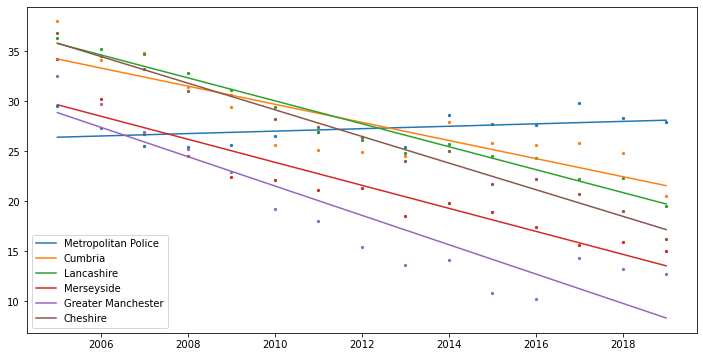

In [5]:
plt.figure(figsize=(12, 6));
years = np.arange(2005, 2020, 1).astype(np.int)
print(years.shape)
for i in range(6):
    plt.scatter(years, accident_data[i, :], marker='.', s=20)
    fit = np.polyfit(years, accident_data[i, :], 1)
    fitted_values = np.polyval(fit, years)
    plt.plot(years, fitted_values, label=area_names[i])
plt.legend()
plt.show()


### 3.1 Separate Model

In a separate model, we treat each district as an individual entity, and assign independent parameters to them. Specifically, we assign individual parameters $\alpha_i$ and $\beta_i$ to the $i$th area, and make the mean vary linearly with respect to years. But each district will have a constant variance across all 15 years. The mathematical expression for the separate model can be specified with the following equations:
$$
\begin{aligned}
\alpha_i &\sim Normal(0, 100)\\
\beta_i &\sim Normal(0, 4.85)\\
\sigma_j &\sim uniform \\
\mu_{i,j} &= \alpha_i + \beta_i * year[j] \\
accident[i, j] &\sim Normal(\mu_{i,j}, \sigma_j)
\end{aligned}
$$


### 3.3 Hierarchical Model

In [6]:
model_name = 'accident_hierarchical.stan'
stan_model = pystan.StanModel(file=model_path + '/' + model_name)
print(stan_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9fb09f0a30d029d43ce52bd2384506d8 NOW.


//
// This Stan program defines a simple model, with a
// vector of values 'y' modeled as normally distributed
// with mean 'mu' and standard deviation 'sigma'.
//
// Learn more about model development with Stan at:
//
//    http://mc-stan.org/users/interfaces/rstan.html
//    https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started
//

data {
  int<lower=0> N; // the number of police force
  int<lower=0> Y; // the number of years has been studied, year 2005 corresponds to 1
  matrix[N,Y] accidentData;//accident data
  int prior_choice; // choose different setup for prior distribution
  int xpred; // year of prediction (actual year)
}


parameters {
  real mu_alpha;
  real mu_beta;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;
  vector[N] alpha;
  vector[N] beta;
  vector<lower=0>[N] sigma;
}


transformed parameters{
  matrix[N,Y]mu;
  for(i in 1:N)
    for(j in 1:Y)
      mu[i,j]=alpha[i]+beta[i]*j;
}


model {
  if (prior_choice==3){
    // bigger variance
    mu_alph

In [7]:
data_for_stan = dict(
    N = accident_data.shape[0],
    Y = accident_data.shape[1],
    accidentData = accident_data,
    years = np.arange(1, accident_data.shape[1]+1), # stan index starts from 1
    xpred=2020,
    prior_choice=1
)
stan_results = stan_model.sampling(data=data_for_stan)
# print(stan_results)

Computed from 4000 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -186.24     7.58
p_loo       16.04        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       87   96.7%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         2    2.2%
   (1, Inf)   (very bad)    0    0.0%



/home/weijiang/anaconda3/envs/bda/lib/python3.7/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


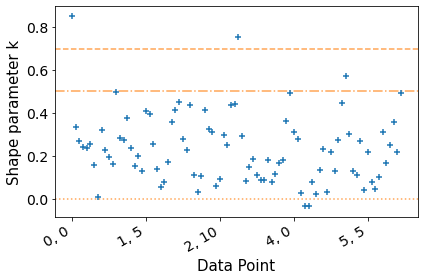

In [8]:
def get_psis_loo_result(stan_results):
    idata = az.from_pystan(stan_results, log_likelihood="log_lik")
    loo_results = az.loo(idata, pointwise=True)
    print(loo_results)
    khats = loo_results.pareto_k
    az.plot_khat(khats, xlabels=True, annotate=True)

get_psis_loo_result(stan_results)

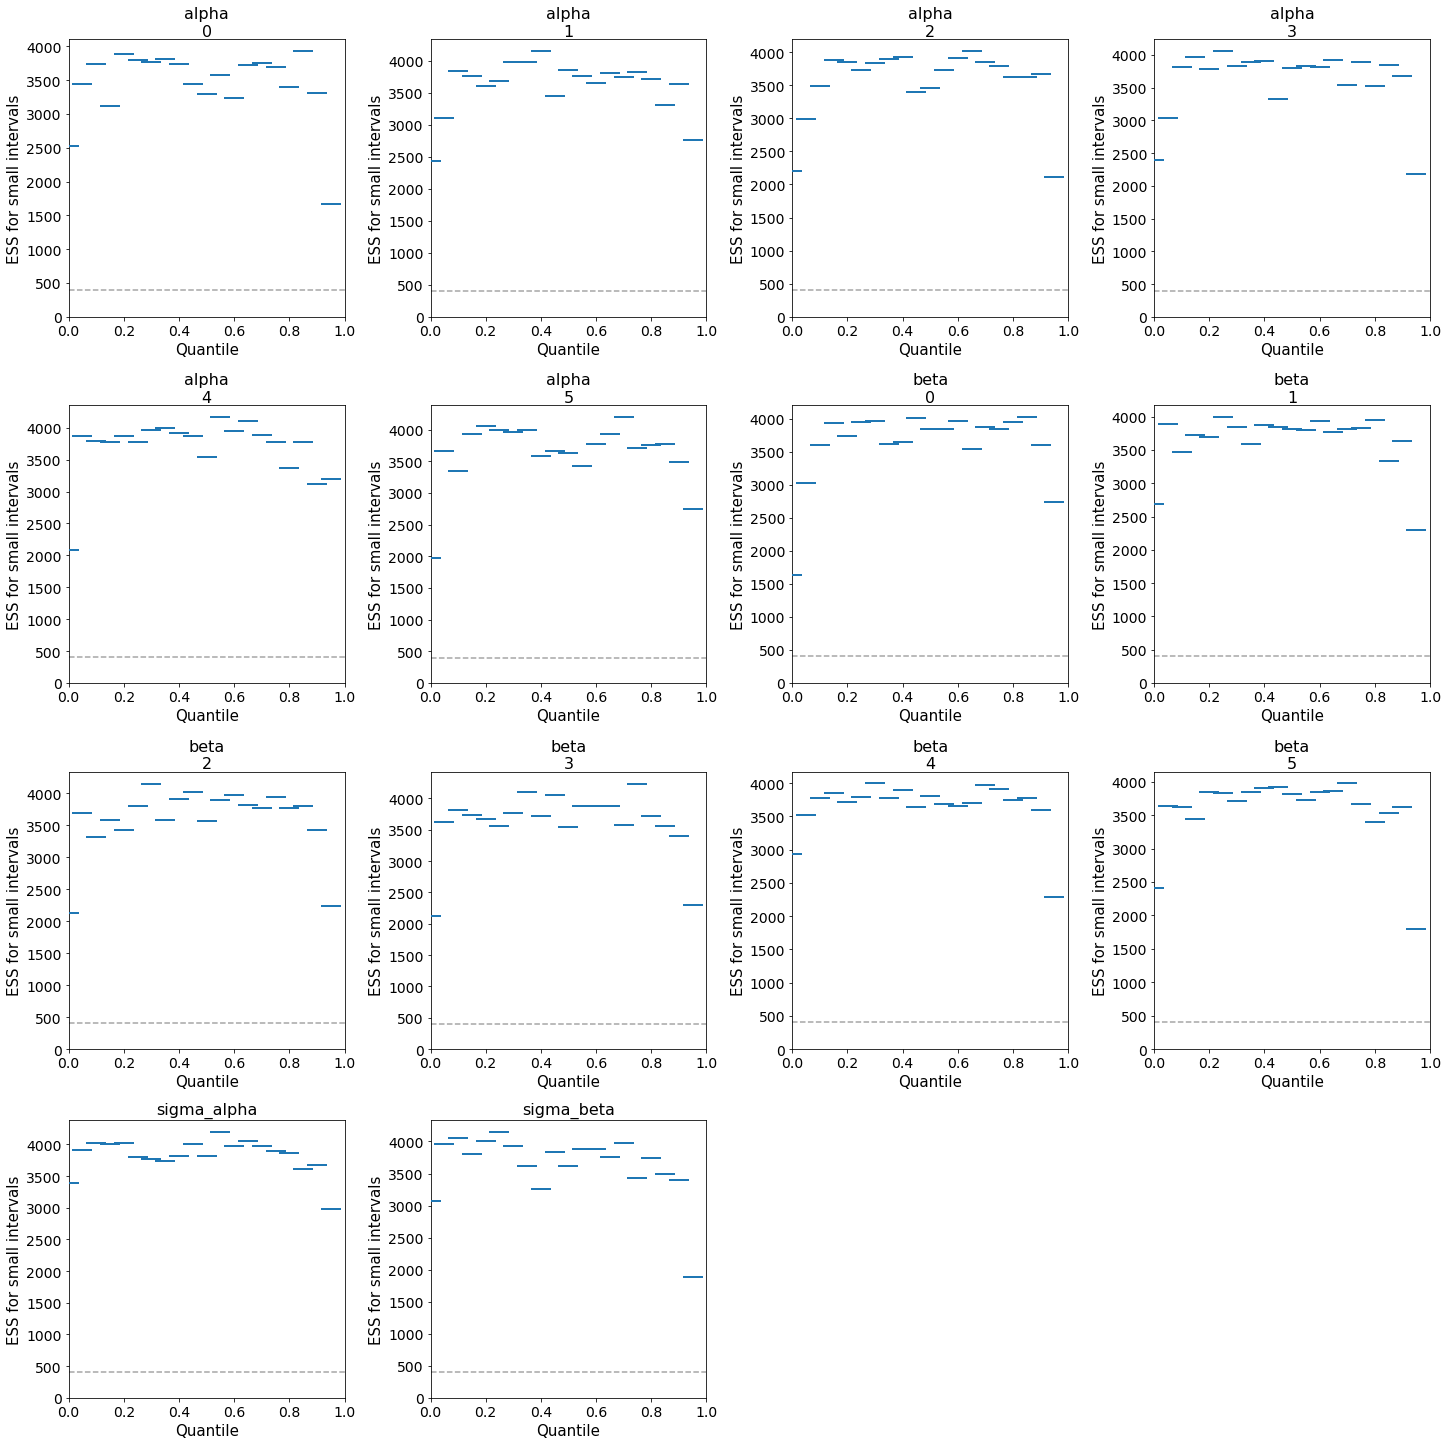

In [9]:
_ = az.plot_ess(
    stan_results, var_names=["alpha", "beta", "sigma_alpha", "sigma_beta"], 
    kind="local", marker="_", ms=20, mew=2, figsize=(20, 20)
)

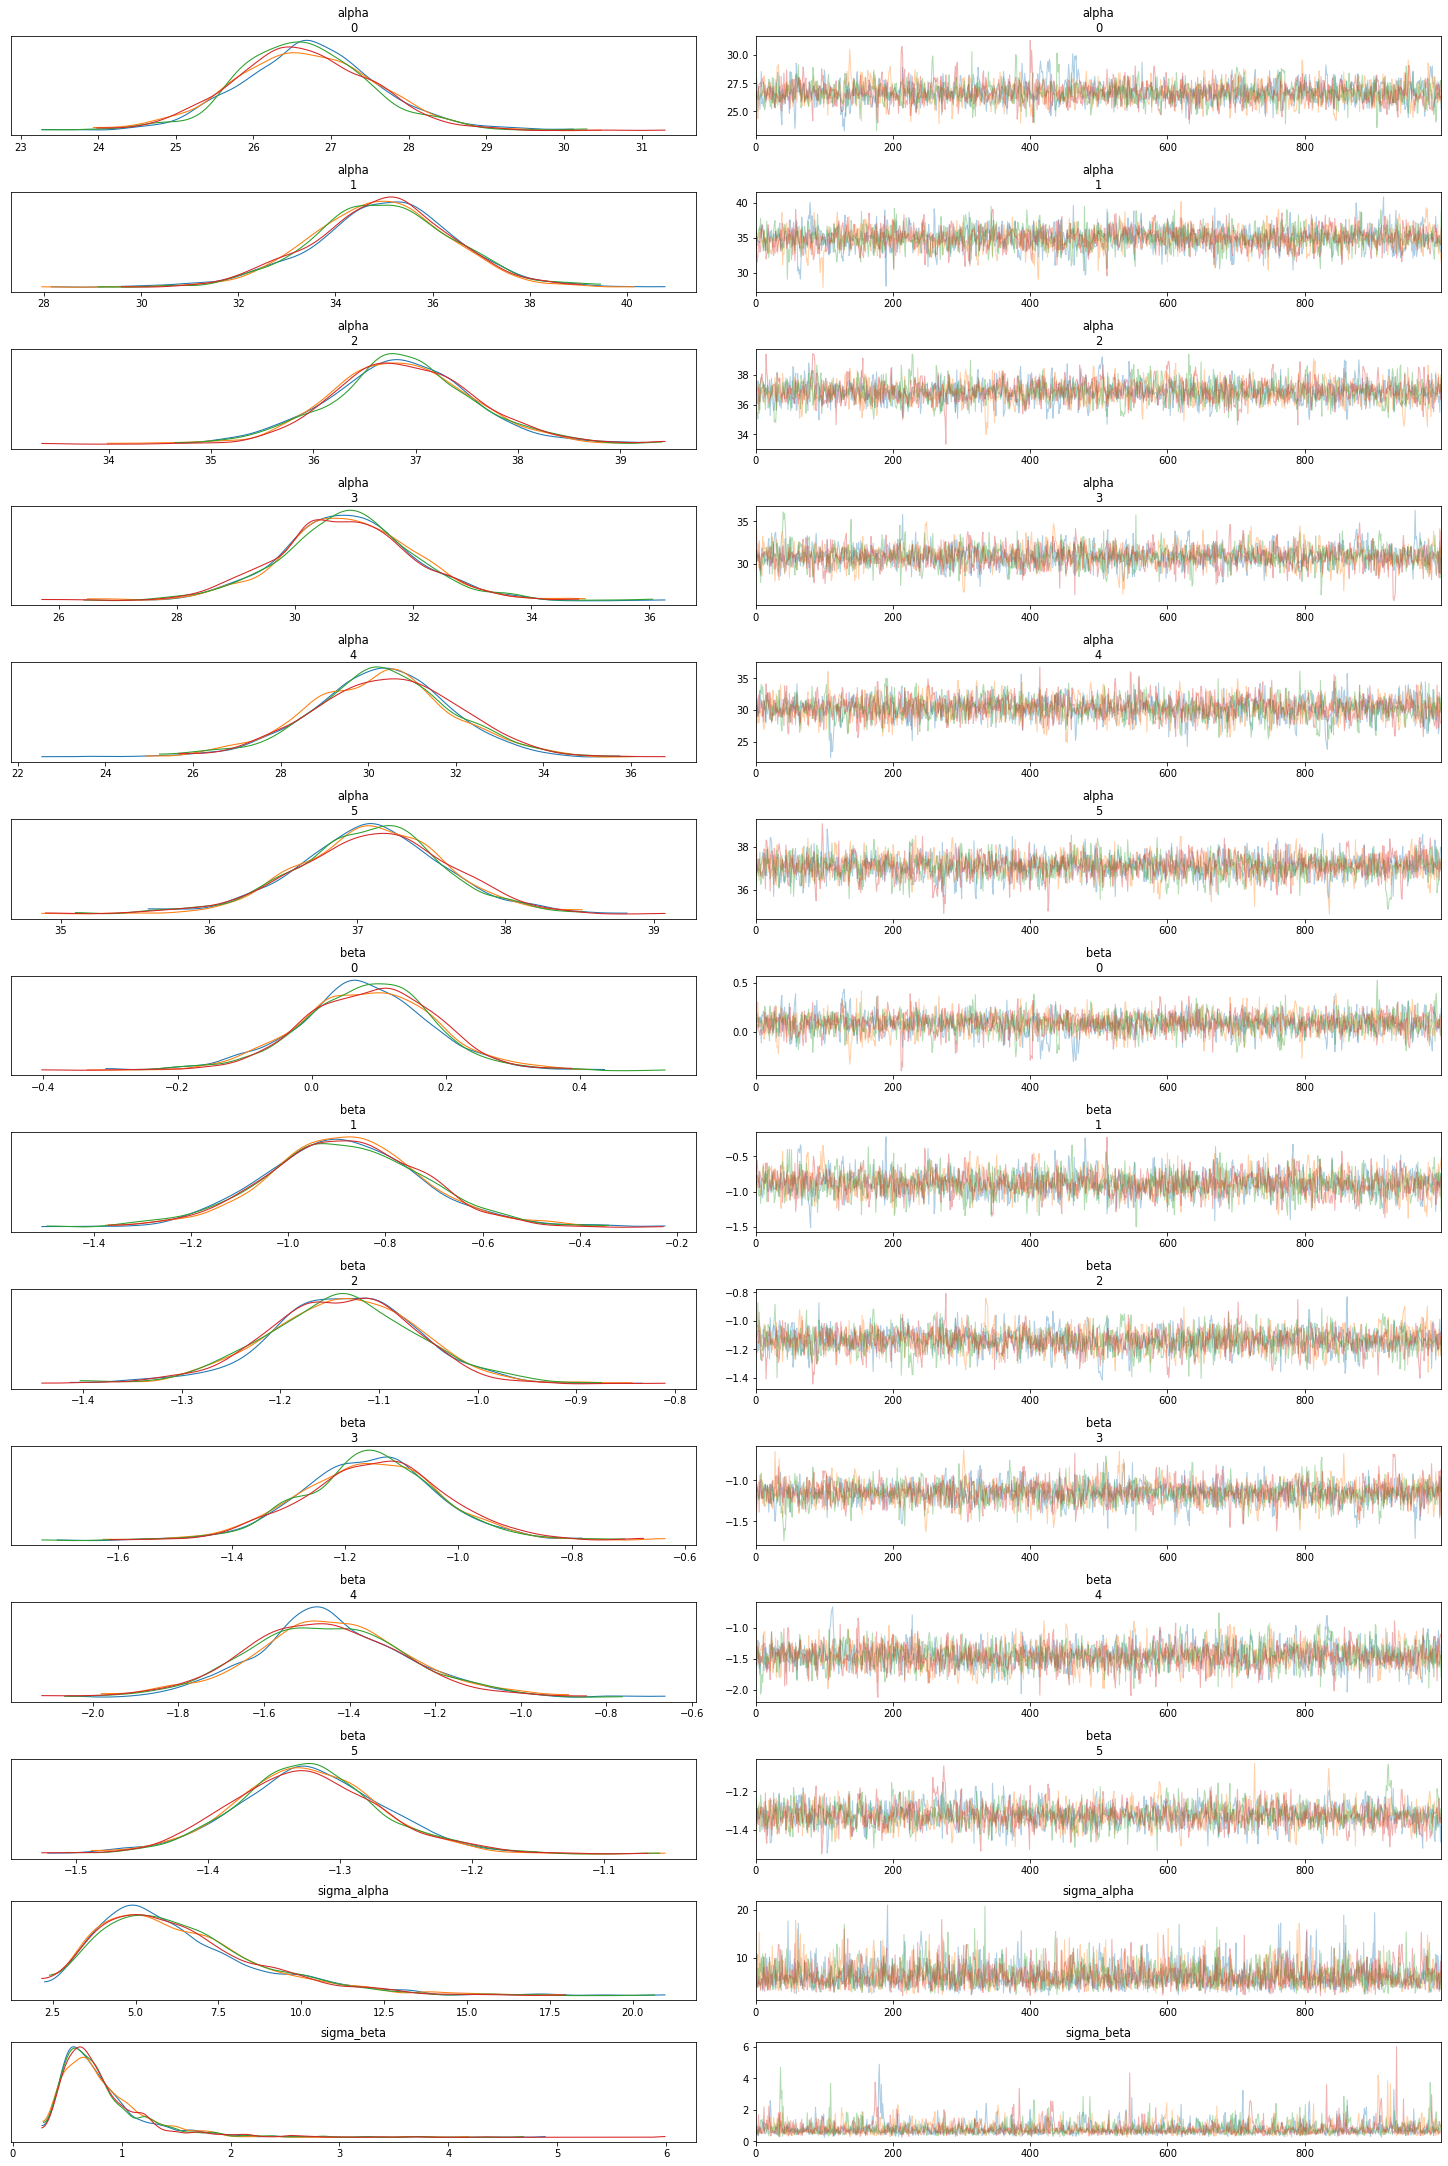

In [10]:
_ = az.plot_trace(stan_results, var_names = ["alpha", "beta", "sigma_alpha", "sigma_beta"], figsize=(20, 30))

In [11]:
h = stan_results.to_dataframe(diagnostics=True)
print('max treedepth for draws: ', h['treedepth__'].max())
print('min treedepth for draws: ', h['treedepth__'].min())
print('mean treedepth for draws: ', h['treedepth__'].mean())
print('divergent transitions: ', any(h['divergent__']))

max treedepth for draws:  6
min treedepth for draws:  3
mean treedepth for draws:  4.0645
divergent transitions:  False


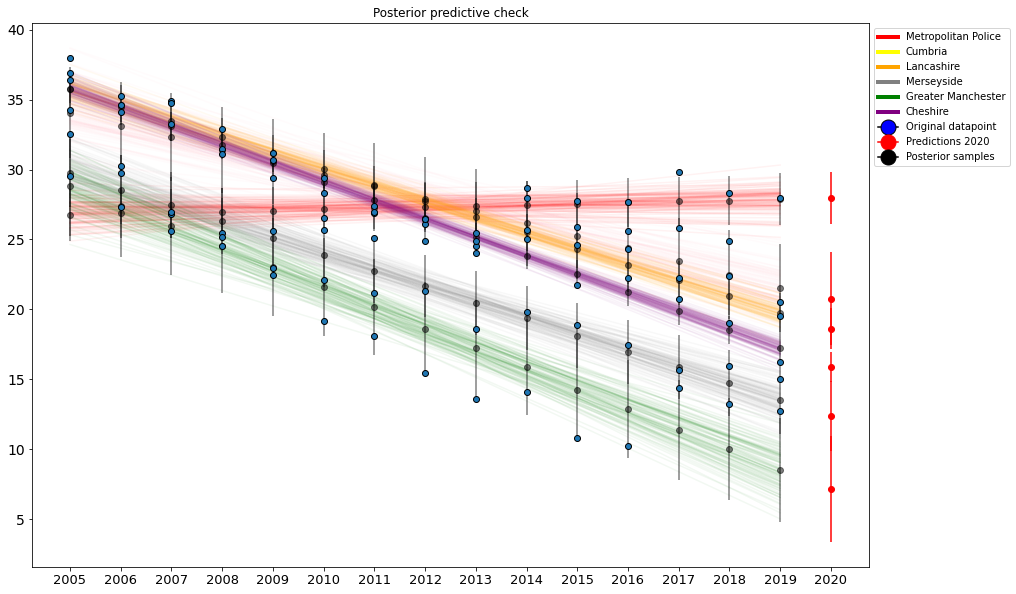

In [12]:
plt.figure(figsize=(15,10))
year_idx = np.arange(accident_data.shape[1])+1
actual_years = year_idx + 2004

colors = ['red', 'pink', 'orange', 'gray', 'green', 'purple']
for x in range(1, 7):
    print()
    for i in range(100):
        y = stan_results["beta"][:, x-1][i] * year_idx + stan_results["alpha"][:, x-1][i]
        _ = plt.plot(actual_years, y, color=colors[x-1], alpha=0.05)
    
for x in range(1, 7):
    for j in reversed(range(1, 16)):
        yrep = stan_results['yrep[{},{}]'.format(x, j)]
        _ = plt.errorbar(
            x = actual_years[j-1], 
            y = np.mean(yrep),
            yerr=np.std(yrep), 
            fmt='--o', zorder=i+j,
            ecolor='black', capthick=2,
            color='black',
            alpha=0.5
        )

for k in range(1, 7):
    ypred = stan_results['pred[{}]'.format(k)] 
    _ = plt.errorbar(
        x = 2020, 
        y = np.mean(ypred), 
        yerr=np.std(ypred), 
        fmt='--o', zorder=i+j+100,
        ecolor='red', capthick=2,
        color='red',
    )


_ = plt.scatter(np.tile(years, 6), accident_data.flatten(), zorder=j+i+100, edgecolors='black')
# _ = plt.scatter(data_for_stan["years"], data_for_stan["accidentData"], zorder=j+i+100, edgecolors='black')
_ = plt.title("Posterior predictive check")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='lower left', borderaxespad=0.)


# area_names = ["Metropolitan Police", 'Cumbria','Lancashire',
#                'Merseyside','Greater Manchester','Cheshire']

custom_lines = [
    Line2D([0], [0], color='red', lw=4, label='Metropolitan Police'),
    Line2D([0], [0], color='yellow', lw=4, label='Cumbria'),
    Line2D([0], [0], color='orange', lw=4, label='Lancashire'),
    Line2D([0], [0], color='gray', lw=4, label='Merseyside'),
    Line2D([0], [0], color='green', lw=4, label='Greater Manchester'),
    Line2D([0], [0], color='purple', lw=4, label='Cheshire'),
    Line2D([0], [0], marker='o', color='black', label='Original datapoint', markerfacecolor='b', markersize=15),
    Line2D([0], [0], marker='o', color='red', label='Predictions 2020', markersize=15),
    Line2D([0], [0], marker='o', color='black', label='Posterior samples', markersize=15),
]

_ = plt.legend(handles=custom_lines, bbox_to_anchor=(1, 1))
_ = plt.xticks(np.arange(2005, 2021), fontsize=13)
_ = plt.yticks(fontsize=14)

In [13]:
data_dict = dict()
names = ["default_prior", "uniform_prior", "bigger_variance"]
for i in range(3):
    current_stan_data = dict(
        N = accident_data.shape[0],
        Y = accident_data.shape[1],
        accidentData = accident_data,
        years = np.arange(1, accident_data.shape[1]+1), # stan index starts from 1
        xpred=2020,
        prior_choice= i+1
    )
    data_dict[names[i]] = current_stan_data

In [14]:
result_dict = dict()
for key, stan_data in data_dict.items():
    print("Generating results with prior:{} {}".format(stan_data["prior_choice"], key))
    sampling_result = stan_model.sampling(data=stan_data)
    #print(sampling_result)
    result_dict[key] = sampling_result

Generating results with prior:1 default_prior
Generating results with prior:2 uniform_prior
Generating results with prior:3 bigger_variance


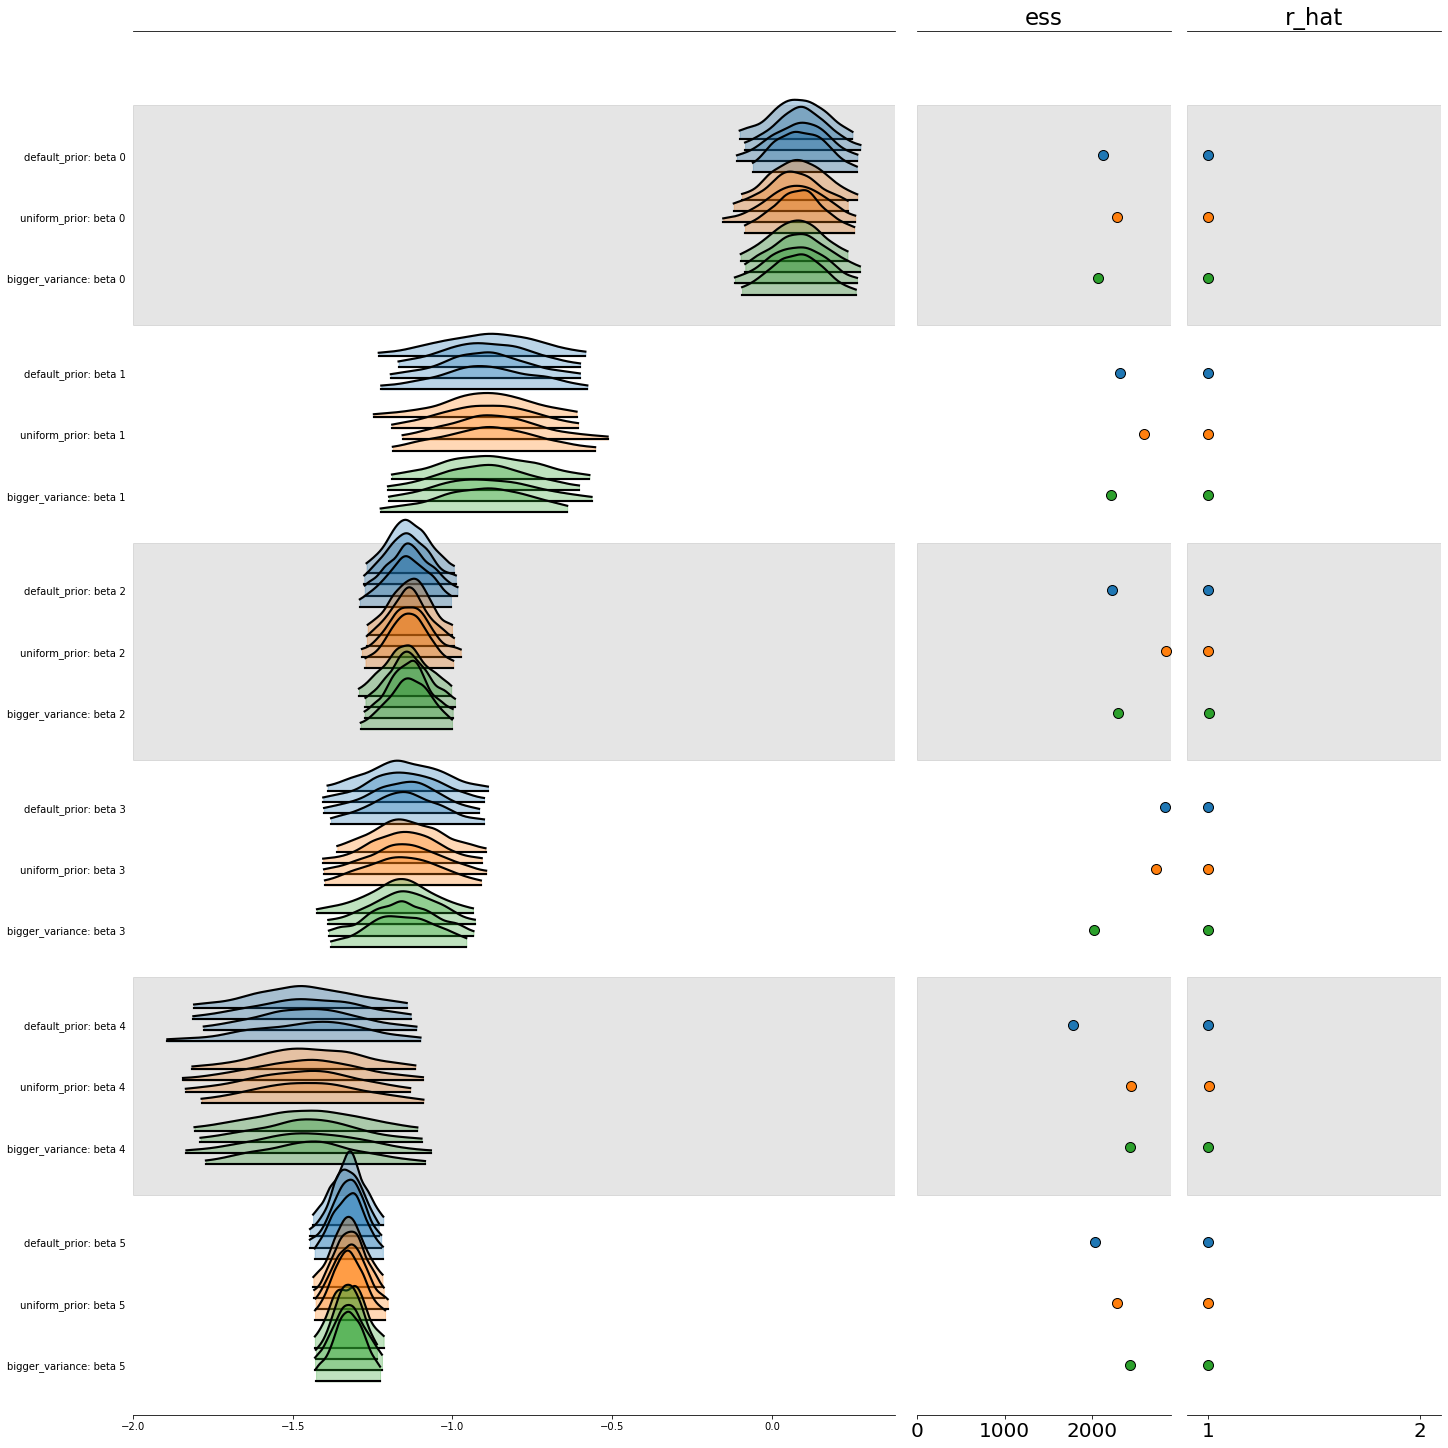

In [15]:
_ = az.plot_forest(
    list(result_dict.values()), 
    model_names=list(result_dict.keys()), var_names=["beta"], markersize=10,
    kind='ridgeplot', ridgeplot_overlap=3, ridgeplot_alpha=0.3, r_hat=True, ess=True, figsize=(20, 20), textsize=20
)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

### For comparing different models (after separate, pooled, hierarchical)

Computed from 4000 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -186.36     7.54
p_loo       16.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       86   95.6%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         1    1.1%
   (1, Inf)   (very bad)    1    1.1%



/home/weijiang/anaconda3/envs/bda/lib/python3.7/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

<Figure size 432x288 with 0 Axes>

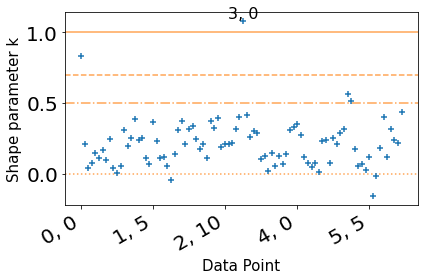

In [16]:
idata = az.from_pystan(stan_results, log_likelihood="log_lik")
loo_results = az.loo(idata, pointwise=True)
print(loo_results)
khats = loo_results.pareto_k
plt.figure()
az.plot_khat(khats, xlabels=True, annotate=True)